# Cyclical SGLD

In this example we will demonstrate how Blackjax can be used to create non-trivial samplers by implementing Cyclical SGLD {cite:p}`zhang2019cyclical`. Stochastic Gradient MCMC algorithms are typically used to sample from the posterior distribution of Bayesian Neural Networks. They differ from other gradient-based MCMC algorithms in that they estimate the gradient with minibatches of data instead of the full dataset.

However, SGMCMC algorithms are inefficient at exploring multimodal distributions which are typical of neural networks. To see this let's consider a simple yet challenging example, an array of 25 gaussian distributions:

In [1]:
import itertools

import jax
import jax.scipy as jsp
import jax.numpy as jnp


lmbda = 1/25
positions = [-4, -2, 0, 2, 4]
mu = jnp.array([list(prod) for prod in itertools.product(positions, positions)])
sigma = 0.03 * jnp.eye(2)

def logprob_fn(x, *_):
    return lmbda * jsp.special.logsumexp(jax.scipy.stats.multivariate_normal.logpdf(x, mu, sigma))

def sample_fn(rng_key):
    choose_key, sample_key = jax.random.split(rng_key)
    samples = jax.random.multivariate_normal(sample_key, mu, sigma)
    return jax.random.choice(choose_key, samples)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'Samples from a mixture of 25 normal distributions')

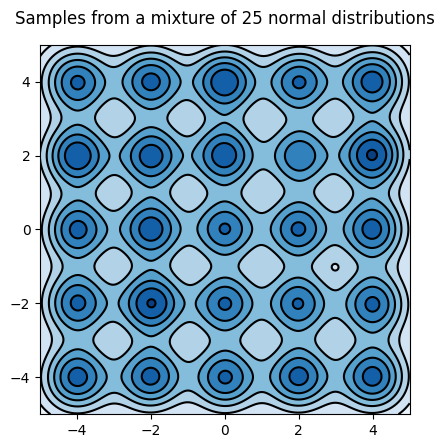

In [2]:
import matplotlib.pylab as plt

import numpy as np
from scipy.stats import gaussian_kde


rng_key = jax.random.PRNGKey(0)
samples = jax.vmap(sample_fn)(jax.random.split(rng_key, 10_000))

xmin, ymin = -5, -5
xmax, ymax = 5, 5

nbins = 300j
x, y = samples[:, 0], samples[:, 1]
xx, yy = np.mgrid[xmin:xmax:nbins, ymin:ymax:nbins]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig, ax = plt.subplots()
cfset = ax.contourf(xx, yy, f, cmap='Blues')
ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')

plt.rcParams['axes.titlepad'] = 15.
plt.title("Samples from a mixture of 25 normal distributions")

## SGLD

Let us build a SGLD sampler with Blackjax with a decreading learning rate, and generate samples from this distribution:

In [3]:
import blackjax
import jax
from fastprogress import progress_bar


# 50k iterations
num_training_steps = 50000
schedule_fn = lambda k: 0.05 * k ** (-0.55)
schedule = [schedule_fn(i) for i in range(1, num_training_steps+1)]

grad_fn = lambda x, _: jax.grad(logprob_fn)(x)
sgld = blackjax.sgld(grad_fn)

rng_key = jax.random.PRNGKey(3)
init_position = -10 + 20 * jax.random.uniform(rng_key, shape=(2,))

position = init_position
sgld_samples = []
for i in progress_bar(range(num_training_steps)):
    _, rng_key = jax.random.split(rng_key)
    position = jax.jit(sgld)(rng_key, position, 0, schedule[i])
    sgld_samples.append(position)

As one can see on the following figure, SGLD has a hard time escaping the mode in which it started, leading to a poor approximation of the distribution:

(-8.0, 8.0, -8.0, 8.0)

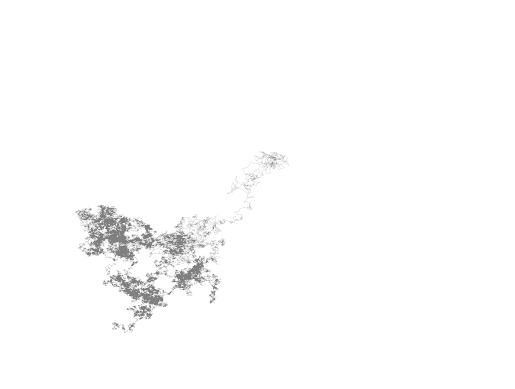

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = [sample[0] for sample in sgld_samples]
y = [sample[1] for sample in sgld_samples]

ax.plot(x, y, 'k-', lw=0.1, alpha=0.5)
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])

plt.axis('off')

## Cyclical SGLD

To escape modes and better explore distributions, Cyclical SLGD alternes between two phases:

1. *Exploration* using Stochastic Gradient Descent with a large-ish step size;
2. *Sampling* using SGLD with a lower learning rate.

### Cyclical schedule

Both the step size and the phase the algorithm is in are governed by a cyclical schedule which is built as follows:

In [5]:
from typing import NamedTuple


class ScheduleState(NamedTuple):
    step_size: float
    do_sample: bool


def build_schedule(
    num_training_steps,
    num_cycles=4,
    initial_step_size=1e-3,
    exploration_ratio=0.25,
):
    cycle_length = num_training_steps // num_cycles

    def schedule_fn(step_id):
        do_sample = False
        if ((step_id % cycle_length)/cycle_length) >= exploration_ratio:
            do_sample = True

        cos_out = jnp.cos(jnp.pi * (step_id % cycle_length) / cycle_length) + 1
        step_size = 0.5 * cos_out * initial_step_size

        return ScheduleState(step_size, do_sample)

    return schedule_fn

Let us visualize a schedule for 200k training steps divided in 4 cycles. At each cycle 1/4th of the steps are dedicated to exploration:

Text(0.5, 1.0, 'Training schedule for Cyclical SGLD')

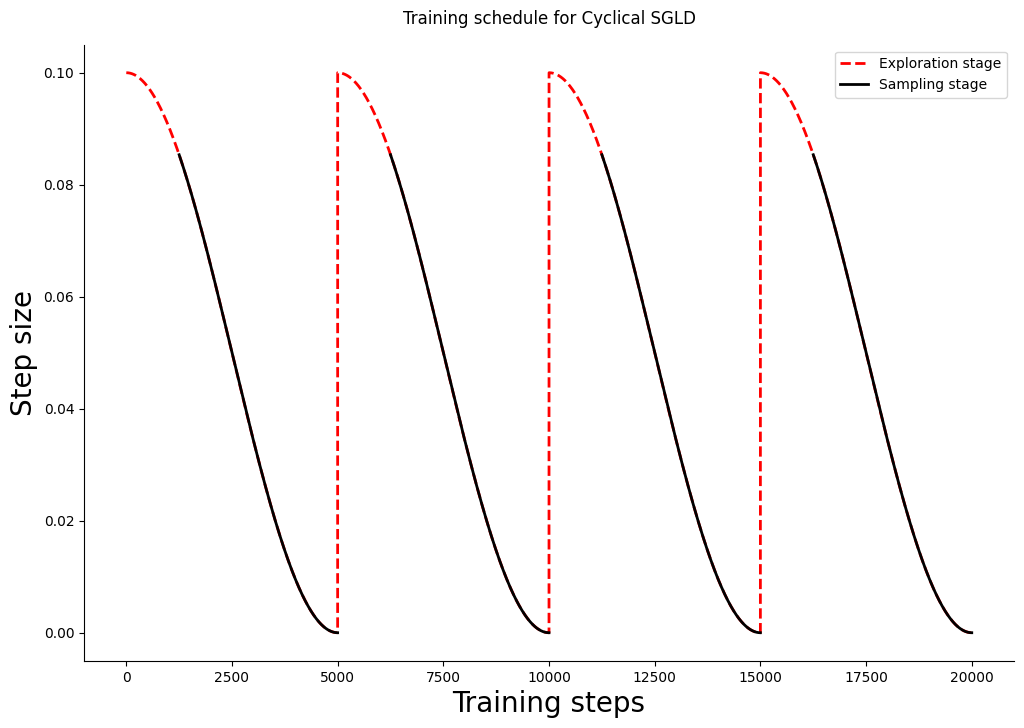

In [6]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt
import numpy as np

schedule_fn = build_schedule(20000, 4, 1e-1)
schedule = [schedule_fn(i) for i in range(20000)]

step_sizes = np.array([step.step_size for step in schedule])
do_sample = np.array([step.do_sample for step in schedule])

sampling_points = np.ma.masked_where(~do_sample, step_sizes)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(step_sizes, lw=2, ls="--", color="r", label="Exploration stage")
ax.plot(sampling_points, lw=2, ls="-", color="k", label="Sampling stage")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_xlabel("Training steps", fontsize=20)
ax.set_ylabel("Step size", fontsize=20)
plt.legend()
plt.title("Training schedule for Cyclical SGLD")

### Step function

Let us now build a step function for the Cyclical SGLD algorithm that can act as a drop-in replacement to the SGLD kernel.

In [7]:
from typing import NamedTuple

import blackjax
import optax

from blackjax.types import PyTree
from optax._src.base import OptState


class CyclicalSGMCMCState(NamedTuple):
    """State of the Cyclical SGMCMC sampler.
    """
    position: PyTree
    opt_state: OptState


def cyclical_sgld(grad_estimator_fn, loglikelihood_fn):

    # Initialize the SgLD step function
    sgld = blackjax.sgld(grad_estimator_fn)
    sgd = optax.sgd(1.)

    def init_fn(position):
        opt_state = sgd.init(position)
        return CyclicalSGMCMCState(position, opt_state)

    def step_fn(rng_key, state, minibatch, schedule_state):
        """Cyclical SGLD kernel."""

        def step_with_sgld(current_state):
            rng_key, state, minibatch, step_size = current_state
            new_position = sgld(rng_key, state.position, minibatch, step_size)
            return CyclicalSGMCMCState(new_position, state.opt_state)

        def step_with_sgd(current_state):
            _, state, minibatch, step_size = current_state
            grads = grad_estimator_fn(state.position, 0)
            rescaled_grads = - 1. * step_size * grads
            updates, new_opt_state = sgd.update(rescaled_grads, state.opt_state, state.position)
            new_position = optax.apply_updates(state.position, updates)
            return CyclicalSGMCMCState(new_position, new_opt_state)

        new_state = jax.lax.cond(
            schedule_state.do_sample,
            step_with_sgld,
            step_with_sgd,
            (rng_key, state, minibatch, schedule_state.step_size)
        )

        return new_state

    return init_fn, step_fn

We leave the implementation of Cyclical SGHMC as an exercise for the reader.

```{note}
If you want to Cyclical SGLD on one of your models you can simply copy and paste the code in the above cell and the cell where the schedule builder is implemented.
```


Let's sample using Cyclical SGLD, for the same number of iterations as with SGLD. We'll use 30 cycles, and sample 75% of the time.

In [8]:
import jax
from fastprogress import progress_bar


# 50k iterations
# M = 30
# initial step size = 0.09
# ratio exploration = 1/4
num_training_steps = 50000
schedule_fn = build_schedule(num_training_steps, 30, 0.09, 0.25)
schedule = [schedule_fn(i) for i in range(num_training_steps)]

grad_fn = lambda x, _: jax.grad(logprob_fn)(x)
init, step = cyclical_sgld(grad_fn, logprob_fn)

rng_key = jax.random.PRNGKey(3)
init_position = -10 + 20 * jax.random.uniform(rng_key, shape=(2,))
init_state = init(init_position)


state = init_state
cyclical_samples = []
for i in progress_bar(range(num_training_steps)):
    _, rng_key = jax.random.split(rng_key)
    state = jax.jit(step)(rng_key, state, 0, schedule[i])
    if schedule[i].do_sample:
        cyclical_samples.append(state.position)

By looking at the trajectory of the sampler it seems that the distribution is much better explored:

Text(0.5, 1.0, 'Trajectory with Cyclical SGLD')

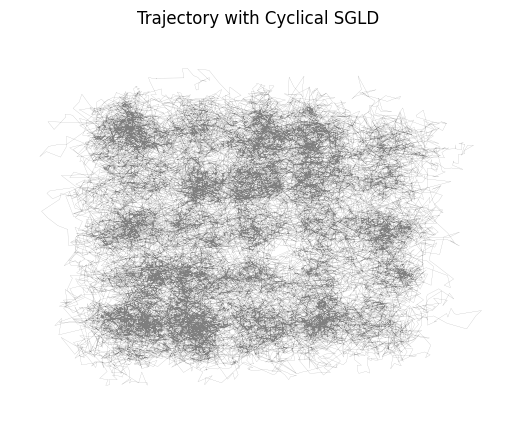

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = [sample[0] for sample in cyclical_samples]
y = [sample[1] for sample in cyclical_samples]

ax.plot(x, y, 'k-', lw=0.1, alpha=0.5)
ax.set_xlim([-8, 8])
ax.set_ylim([-8, 8])

plt.axis('off')
plt.title("Trajectory with Cyclical SGLD")

And the distribution indeed looks more better:

Text(0.5, 1.0, 'Samples from a mixture of 25 normal distributions')

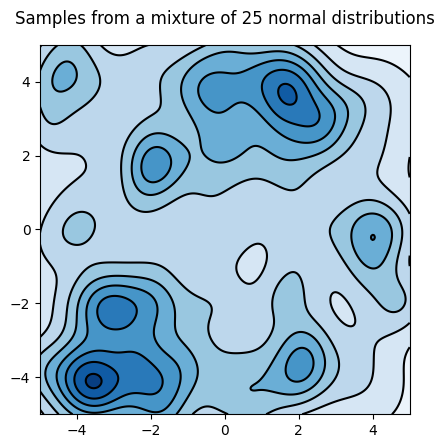

In [10]:
import matplotlib.pylab as plt

import numpy as np
from scipy.stats import gaussian_kde

xmin, ymin = -5, -5
xmax, ymax = 5, 5

nbins = 300j
x = [sample[0] for sample in cyclical_samples]
y = [sample[1] for sample in cyclical_samples]
xx, yy = np.mgrid[xmin:xmax:nbins, ymin:ymax:nbins]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig, ax = plt.subplots()
cfset = ax.contourf(xx, yy, f, cmap='Blues')
ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='k')

plt.rcParams['axes.titlepad'] = 15.
plt.title("Samples from a mixture of 25 normal distributions")

```{warning}
SciPy's `gaussian_kde` assumes that the total number of points provided is the sample size, it is thus not fit to use with raw MCMC samples. We should instead pass the bandwidth manually $n_{eff}^{-1/6}$ where $n_{eff}$ is the effective number of samples, and the figure should capture more modes.
```


```{bibliography}
:filter: docname in docnames
```